## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import random
import seaborn as sns

%matplotlib inline

In [39]:
# Load data:
df = pd.read_csv("house_prices.csv")

In [40]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [41]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

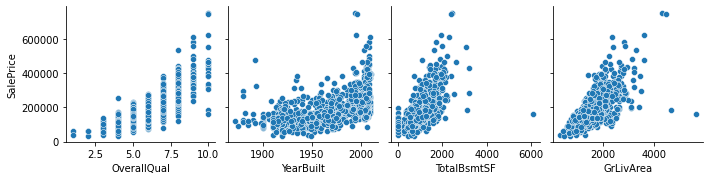

In [42]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [43]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] # get the target values

In [44]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

In [45]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(4, 1)
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [46]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [47]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.

In [48]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):
#             print(X, y)

            y_pre = model(X).view(-1)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
#             print(loss.item())
            
        if ((epoch+1)%1 == 0):
                print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss))
                

In [49]:
train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss_error: nan
Epoch [2/10], Loss_error: nan
Epoch [3/10], Loss_error: nan
Epoch [4/10], Loss_error: nan
Epoch [5/10], Loss_error: nan
Epoch [6/10], Loss_error: nan
Epoch [7/10], Loss_error: nan
Epoch [8/10], Loss_error: nan
Epoch [9/10], Loss_error: nan
Epoch [10/10], Loss_error: nan


#### Evaluate the Model on the validation set

In [50]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: nan


In [51]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Preprocessing

Since the dataset contains large values, we normalize them with min max scaler fitted on the training set.

In [114]:
def preprocess(X, y, test_split=0.2, val_split=0.2):
    X = X.to_numpy()
    y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split/(1-test_split), random_state=1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_val = min_max_scaler.transform(X_val)
    X_test = min_max_scaler.transform(X_test)

    # labels
    min_max_scaler_y = preprocessing.MinMaxScaler()
    y_train = min_max_scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_val = min_max_scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)
    y_test = min_max_scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    train_set = TensorDataset(X_train, y_train)
    val_set = TensorDataset(X_val, y_val)
    test_set = TensorDataset(X_test, y_test)

    return train_set, val_set, test_set

In [115]:
from torch.utils.data import DataLoader

class Model(nn.Module):
    def __init__(self, model, label_reshaper=None):
        super().__init__()
        self.model = model
        self.label_reshaper = label_reshaper

    def forward(self, x):
        output = self.model(x)
        return output

    def predict(self, dataset):
        self.eval()
        X, y = iter(DataLoader(dataset, batch_size=len(dataset))).next()
        predictions = self.forward(X)
        return predictions

    def evaluate(self, dataset, metrics):
        self.eval()
        X, y = iter(DataLoader(dataset, batch_size=len(dataset))).next()
        if self.label_reshaper:
                    y = self.label_reshaper(y)
        y_hat = self.forward(X)
        results = [metric[1](y, y_hat) for metric in metrics]
        return results

    def fit(self, train_set, val_set, loss_function, optimizer, metrics, num_epochs=20, batch_size=32, shuffle=True, verbose=5):

        # Defining the loaders
        train_loader = DataLoader(train_set, batch_size=batch_size)        
        
        loss_log = []
        val_loss_log = []
        metrics_logs = [[] for metric in metrics]
        val_metrics_logs = [[] for metric in metrics]

        # B-Training
        for epoch in range(num_epochs):
            # Training
            self.train()
            for x, y in train_loader:
                if self.label_reshaper:
                    y = self.label_reshaper(y)
                optimizer.zero_grad()
                y_hat = self.forward(x)
                loss = loss_function(y_hat, y)
                loss.backward()
                optimizer.step()
            
            # Logs
            self.eval()
            ## training set logs
            x, y = iter(DataLoader(train_set, batch_size=len(train_set))).next()
            if self.label_reshaper:
                    y = self.label_reshaper(y)
            y_hat = self.forward(x)
            loss = loss_function(y_hat, y)
            loss_log.append(loss.item())
            for idx, metric in enumerate(metrics):
                metrics_logs[idx].append(metric[1](y_hat, y)) 
                        
            ## validation set logs
            x, y = iter(DataLoader(val_set, batch_size=len(val_set))).next()
            if self.label_reshaper:
                    y = self.label_reshaper(y)
            y_hat = self.forward(x)
            loss = loss_function(y_hat, y)
            val_loss_log.append(loss.item())
            for idx, metric in enumerate(metrics):
                val_metrics_logs[idx].append(metric[1](y_hat, y))
            
            # Print logs
            if verbose and (epoch+1)%verbose == 0 or epoch==0:
                print("epoch: ", epoch+1)
                print("Training Loss: ", loss_log[epoch])
                print("Validation Loss: ", val_loss_log[epoch])
                for idx, metric in enumerate(metrics):
                    print(f"Training {metric[0]}: {metrics_logs[idx][epoch]}")
                    print(f"Validation {metric[0]}: {val_metrics_logs[idx][epoch]}")
        
        return loss_log, val_loss_log, metrics_logs, val_metrics_logs

In [120]:
def run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=0, val_split=0.2, num_epochs=20, lr=0.01, batch_size=32, shuffle=True, verbose=5, initializer=None, label_reshaper=None):
    # Prepare dataset
    train_set, val_set, test_set = preprocess(dataset[0], dataset[1], test_split=test_split, val_split=val_split)

    # Instanciating the model
    model = Model(model, label_reshaper)

    # Applying weight initialization should the method be supplied
    if initializer is not None:
        model.apply(initializer)
        if verbose:
            print("Applied weight initialization")
    
    # Training the model
    loss_log, val_loss_log, metrics_logs, val_metrics_logs = model.fit(train_set, val_set, loss_function=loss_function, optimizer=optimizer, metrics=metrics, num_epochs=num_epochs, batch_size=batch_size, shuffle=shuffle, verbose=verbose)

    # Plotting results
    epoch_range = np.arange(num_epochs, dtype=int) + 1

    # Compute the number of rows for plotting the results given that we want 3 columns max per row
    n_metrics = len(metrics)
    n_columns = max(2, min(n_metrics, 3))
    n_rows = int(n_metrics / n_columns) + 1
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_columns, squeeze=False, figsize=(12,8))
    fig.tight_layout()

    walk = -1
    for ir, row in enumerate(ax):
        for ic, col in enumerate(row):
            if walk == -1: # loss function
                col.plot(epoch_range, loss_log, 'ro-', label='Training Loss')
                col.plot(epoch_range, val_loss_log, 'bx--', label='Validation Loss')
                col.legend()
                col.set_xlabel("Epoch")
                col.set_ylabel("Loss")
            elif walk < n_metrics:
                col.plot(epoch_range, metrics_logs[walk], 'ro-', label='Training '+metrics[walk][0])
                col.plot(epoch_range, val_metrics_logs[walk], 'bx--', label='Validation '+metrics[walk][0])
                col.legend()
                col.set_xlabel("Epoch")
                col.set_ylabel(metrics[walk][0])
            else:
                ax[ir, ic].axis('off')
                continue
            walk += 1
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

    # Evaluate model
    if len(test_set) > 0:
        results = model.evaluate(test_set, metrics)

        # Print test evaluation results
        for i, metric in enumerate(metrics):
            print(f"Test {metrics[i][0]}: ", "%.2f" % round(results[i], 2))
    

    elif len(val_set) > 0:
        results = model.evaluate(val_set, metrics)

        # Print validation evaluation results
        for i, metric in enumerate(metrics):
            print(f"Validation {metrics[i][0]}: ", "%.2f" % round(results[i], 2))

    return model


In [121]:
# dataset = TensorDataset(torch.from_numpy(X.to_numpy()).float(), torch.from_numpy(y.to_numpy()))
dataset = (X,y)

In [122]:
# Global config
val_split=0.2
test_split=0.2
shuffle=True
initializer=None
metrics = [("MSE Error", lambda y_hat, y: nn.MSELoss()(y_hat, y).item())]

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

epoch:  1
Training Loss:  0.015897871926426888
Validation Loss:  0.013466320000588894
Training MSE Error: 0.015897871926426888
Validation MSE Error: 0.013466320000588894
epoch:  30
Training Loss:  0.010554873384535313
Validation Loss:  0.008844076655805111
Training MSE Error: 0.010554873384535313
Validation MSE Error: 0.008844076655805111
epoch:  60
Training Loss:  0.008788625709712505
Validation Loss:  0.007163228467106819
Training MSE Error: 0.008788625709712505
Validation MSE Error: 0.007163228467106819
epoch:  90
Training Loss:  0.0064353118650615215
Validation Loss:  0.004946762230247259
Training MSE Error: 0.0064353118650615215
Validation MSE Error: 0.004946762230247259


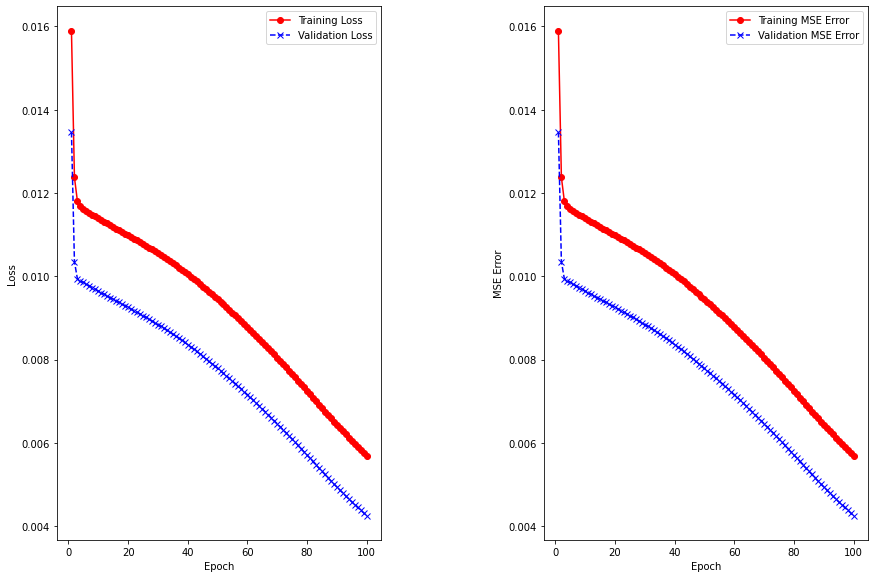

Test MSE Error:  0.01


In [126]:
# model
model = nn.Sequential(
    nn.Linear(4, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 1))

num_epochs = 100
batch_size = 32
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
verbose=30

def mse_reshaper(y):
    return y.reshape(-1, 1).float()

label_reshaper=mse_reshaper

#run experiment
model_trained = run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


epoch:  1
Training Loss:  0.022107817232608795
Validation Loss:  0.019154706969857216
Training MSE Error: 0.022107817232608795
Validation MSE Error: 0.019154706969857216
epoch:  30
Training Loss:  0.0099188182502985
Validation Loss:  0.008138836361467838
Training MSE Error: 0.0099188182502985
Validation MSE Error: 0.008138836361467838
epoch:  60
Training Loss:  0.00784553773701191
Validation Loss:  0.006192292086780071
Training MSE Error: 0.00784553773701191
Validation MSE Error: 0.006192292086780071
epoch:  90
Training Loss:  0.005952539853751659
Validation Loss:  0.00444425456225872
Training MSE Error: 0.005952539853751659
Validation MSE Error: 0.00444425456225872


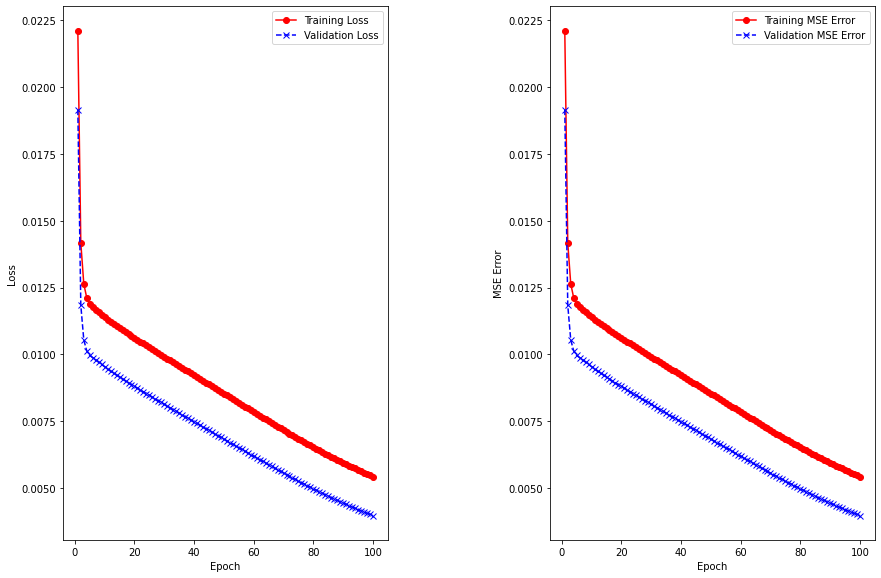

Test MSE Error:  0.01


Model(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [128]:
# model
model = nn.Sequential(
    nn.Linear(4, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

num_epochs = 100
batch_size = 32
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
verbose=30

def mse_reshaper(y):
    return y.reshape(-1, 1).float()

label_reshaper=mse_reshaper

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


epoch:  1
Training Loss:  0.026766857132315636
Validation Loss:  0.0261639766395092
Training MSE Error: 0.026766857132315636
Validation MSE Error: 0.0261639766395092
epoch:  30
Training Loss:  0.011069005355238914
Validation Loss:  0.00940646417438984
Training MSE Error: 0.011069005355238914
Validation MSE Error: 0.00940646417438984
epoch:  60
Training Loss:  0.010218735784292221
Validation Loss:  0.008603655733168125
Training MSE Error: 0.010218735784292221
Validation MSE Error: 0.008603655733168125
epoch:  90
Training Loss:  0.009455390274524689
Validation Loss:  0.007884260267019272
Training MSE Error: 0.009455390274524689
Validation MSE Error: 0.007884260267019272


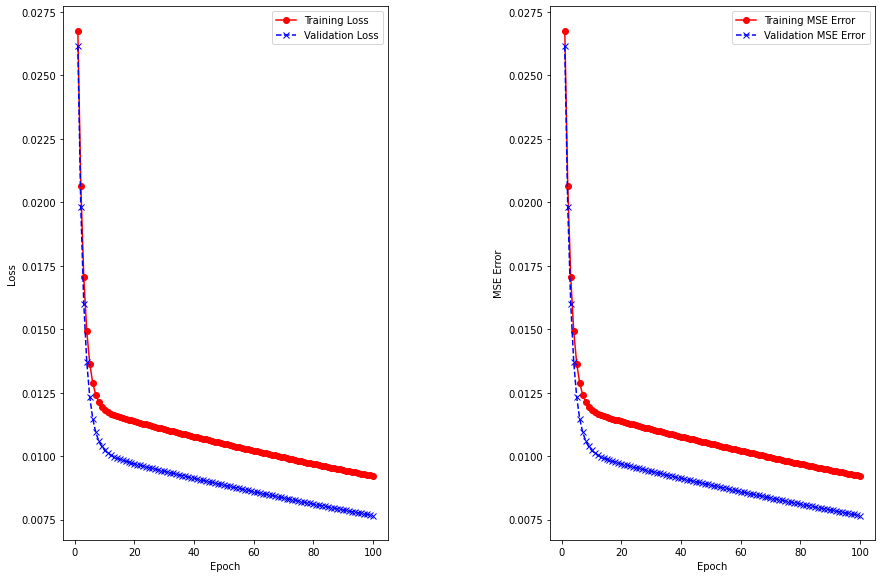

Test MSE Error:  0.01


Model(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [130]:
# model
model = nn.Sequential(
    nn.Linear(4, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 10),
    nn.Tanh(),
    nn.Linear(10, 1))

num_epochs = 100
batch_size = 32
loss_function = nn.MSELoss()
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
verbose=30

def mse_reshaper(y):
    return y.reshape(-1, 1).float()

label_reshaper=mse_reshaper

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

epoch:  1
Training Loss:  0.009117137640714645
Validation Loss:  0.007738590240478516
Training MSE Error: 0.009117137640714645
Validation MSE Error: 0.007738590240478516
epoch:  30
Training Loss:  0.002361105289310217
Validation Loss:  0.001706020557321608
Training MSE Error: 0.002361105289310217
Validation MSE Error: 0.001706020557321608
epoch:  60
Training Loss:  0.0031693342607468367
Validation Loss:  0.0023969209287315607
Training MSE Error: 0.0031693342607468367
Validation MSE Error: 0.0023969209287315607
epoch:  90
Training Loss:  0.0025255181826651096
Validation Loss:  0.0019641343969851732
Training MSE Error: 0.0025255181826651096
Validation MSE Error: 0.0019641343969851732


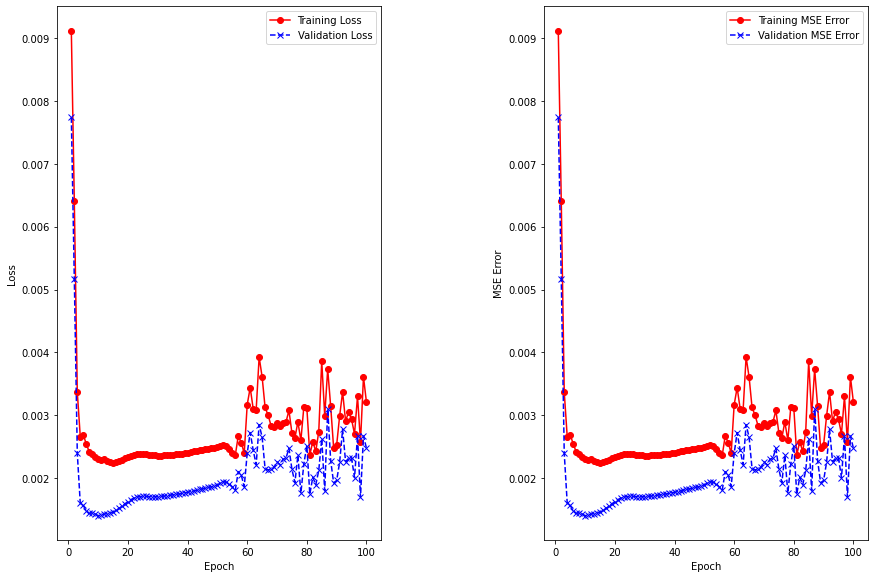

Test MSE Error:  0.00


Model(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [131]:
# model
model = nn.Sequential(
    nn.Linear(4, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 10),
    nn.Tanh(),
    nn.Linear(10, 1))

num_epochs = 100
batch_size = 32
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
verbose=30

def mse_reshaper(y):
    return y.reshape(-1, 1).float()

label_reshaper=mse_reshaper

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


In [140]:
# Gaussian loss function
def GaussianLoss(outputs, targets):
    mu, log_s = outputs[:,0], outputs[:,1]
    targets = targets.view(-1)
    mu = mu.view(-1)
    log_s = log_s.view(-1)
    s = torch.exp(log_s) 
    ecart = 0.5*(1/s)*(targets-mu)**2
    loss = torch.mean(log_s + ecart)
    return loss

epoch:  1
Training Loss:  -1.1832389831542969
Validation Loss:  -1.1866062879562378
epoch:  30
Training Loss:  -5.432887077331543
Validation Loss:  -5.8176069259643555
epoch:  60
Training Loss:  -5.683587074279785
Validation Loss:  -6.083691120147705
epoch:  90
Training Loss:  -6.054222106933594
Validation Loss:  -6.339292526245117


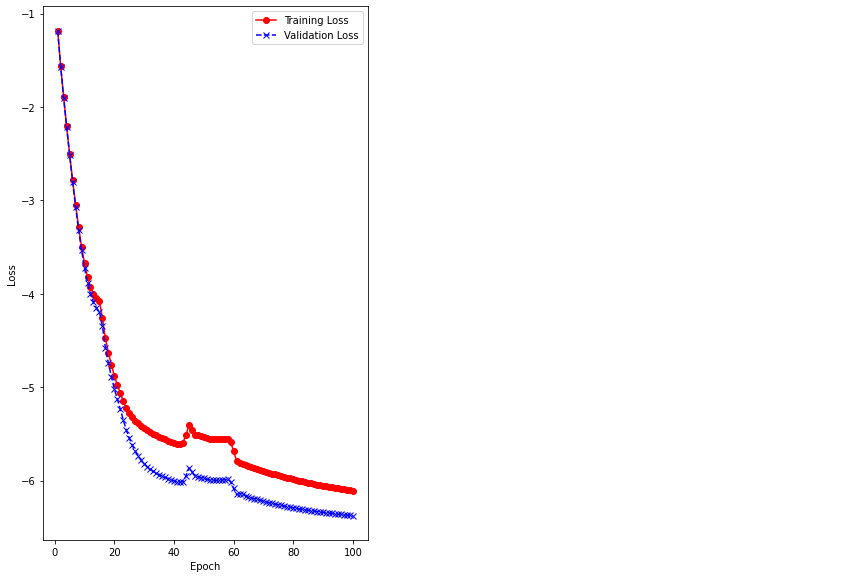

Model(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [142]:
# model
model = nn.Sequential(
    nn.Linear(4, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 10),
    nn.Tanh(),
    nn.Linear(10, 2))

num_epochs = 100
batch_size = 32
loss_function = GaussianLoss
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
verbose=30

def mse_reshaper(y):
    return y.reshape(-1, 1).float()

label_reshaper=mse_reshaper

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics=[], test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.